In [1]:
cd /home/ubuntu/FedEM/

/home/ubuntu/FedEM


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from torch.utils.tensorboard import SummaryWriter
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *

from transfer_attacks.TA_utils import *
from transfer_attacks.Boundary_Transferer import *

In [5]:
# Manually set argument parameters
args_ = Args()
args_.experiment = "cifar10"
args_.method = "FedEM_adv"
args_.decentralized = False
args_.sampling_rate = 1.0
args_.input_dimension = None
args_.output_dimension = None
args_.n_learners= 3
args_.n_rounds = 10
args_.bz = 128
args_.local_steps = 1
args_.lr_lambda = 0
args_.lr =0.03
args_.lr_scheduler = 'multi_step'
args_.log_freq = 10
args_.device = 'cuda'
args_.optimizer = 'sgd'
args_.mu = 0
args_.communication_probability = 0.1
args_.q = 1
args_.locally_tune_clients = False
args_.seed = 1234
args_.verbose = 1
args_.save_path = 'weights/cifar/22_01_09_fedavg_n80_benign/'
args_.validation = False
args_.num_user = 40

# Generate the dummy values here
aggregator, clients = dummy_aggregator(args_, num_user=40)

==> Clients initialization..
===> Building data iterators..


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 199.08it/s]


===> Initializing clients..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:56<00:00,  1.42it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.226% |Test Loss: 2.292 | Test Acc: 12.747% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################


In [6]:
# Combine Validation Data across all clients as test
data_x = []
data_y = []

for i in range(len(clients)):
    daniloader = clients[i].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)
        data_y.append(y)

data_x = torch.stack(data_x)
data_y = torch.stack(data_y)

# Create dataloader from validation dataset that allows for diverse batch size
dataloader = Custom_Dataloader(data_x, data_y)

In [17]:
# exp_names = ['weights/neurips/cifar/prop/none/prop_n1/',
#              'weights/neurips/cifar/prop/none/prop_n2/',
#              'weights/neurips/cifar/prop/none/prop_n5/',
#              'weights/neurips/cifar/prop/none/prop_n10/',
#              'weights/neurips/cifar/prop/none/prop_n20/',
#              'weights/neurips/cifar/prop/none/prop_n40/']

exp_names = ['weights/neurips/cifar/prop/with/prop_n1/',
             'weights/neurips/cifar/prop/with/prop_n2/',
             'weights/neurips/cifar/prop/with/prop_n5/',
             'weights/neurips/cifar/prop/with/prop_n10/',
             'weights/neurips/cifar/prop/with/prop_n20/',
             'weights/neurips/cifar/prop/with/prop_n40/']

train_item = 'train_client_weights.npy'

In [18]:
num_victims = 40
num_exp = len(exp_names)
# Set Up Dictionaries -- list holds the adversary idx
exp_logs = {}

for j in range(num_exp):
    logs_adv = []

    for i in range(num_victims):
        adv_dict = {}
        adv_dict['orig_acc_transfers'] = None
        adv_dict['orig_similarities'] = None
        adv_dict['adv_acc_transfers'] = None
        adv_dict['adv_similarities_target'] = None
        adv_dict['adv_similarities_untarget'] = None
        adv_dict['adv_target'] = None
        adv_dict['adv_miss'] = None
        adv_dict['metric_alignment'] = None
        adv_dict['ib_distance_legit'] = None
        adv_dict['ib_distance_adv'] = None
        
        logs_adv += [adv_dict]
    
    exp_logs[j] = copy.deepcopy(logs_adv)


In [19]:
# Inter Boundary Distance Metric
custom_batch_size = 500


for j in range(num_exp):
    print('processing file', exp_names[j], '...')
    
    # Change name if need be
    args_.save_path = exp_names[j]

    # Import weights for aggregator
    aggregator.load_state(args_.save_path)

    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]
        
    weight_name = args_.save_path + train_item
    weights = np.load(weight_name)
    np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

    # Set model weights
    model_weights = []
    num_models = num_victims

    for i in range(num_models):
        model_weights += [weights[i]]


    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for (w0,w1,w2) in model_weights:
        # first make the model with empty weights
        new_model = copy.deepcopy(hypotheses[0].model)
        new_model.eval()
        new_weight_dict = copy.deepcopy(weights_h[0])
        for key in weights_h[0]:
            new_weight_dict[key] = w0*weights_h[0][key]  + w1*weights_h[1][key] +w2*weights_h[2][key] 
        new_model.load_state_dict(new_weight_dict)
        models_test += [new_model]
    

    victim_idxs = range(num_victims)

    for adv_idx in victim_idxs:
        print("\t Adv idx:", adv_idx)
        # Perform Attacks
        dataloader = load_client_data(clients = clients, c_id = adv_idx, mode = 'test') # or test/train
        batch_size = min(custom_batch_size, dataloader.y_data.shape[0])
        
        t1 = Transferer(models_list=models_test, dataloader=dataloader)
        t1.generate_victims(victim_idxs)
        
        t1.atk_params = PGD_Params()
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = 3, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.05, step_norm = "inf", eps = 4, eps_norm = 2)

        t1.generate_advNN(adv_idx)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        # t1.check_empirical_metrics(orig_flag = True)

        # Log Performance
        exp_logs[j][adv_idx]['orig_acc_transfers'] = copy.deepcopy(t1.orig_acc_transfers)
        exp_logs[j][adv_idx]['orig_similarities'] = copy.deepcopy(t1.orig_similarities)
        exp_logs[j][adv_idx]['adv_acc_transfers'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_target'] = copy.deepcopy(t1.adv_similarities)        
        exp_logs[j][adv_idx]['adv_target'] = copy.deepcopy(t1.adv_target_hit)

        # Miss attack
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.05, step_norm = "inf", eps = 4, eps_norm = 2)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        exp_logs[j][adv_idx]['adv_miss'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_untarget'] = copy.deepcopy(t1.adv_similarities)


    del models_test

processing file weights/neurips/cifar/prop/with/prop_n1/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39
processing file weights/neurips/cifar/prop/with/prop_n2/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 

Organizing and plotting data

In [20]:
metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
           'adv_similarities_untarget','adv_target','adv_miss'] #,'metric_alignment']


orig_acc = []
orig_sim = []
adv_acc = []
adv_sim_target = []
adv_sim_untarget = []
adv_target = []
adv_miss = []

for i in range(len(exp_names)):
    orig_acc += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    orig_sim += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_acc += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_target += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_untarget += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_target += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_miss += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    
    for adv_idx in range(len(victim_idxs)):
        for victim in range(len(victim_idxs)):
            orig_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[0]][victim_idxs[victim]].data.tolist()
            orig_sim[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[1]][victim_idxs[victim]].data.tolist()
            adv_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[2]][victim_idxs[victim]].data.tolist()
            adv_sim_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[3]][victim_idxs[victim]].data.tolist()
            adv_sim_untarget[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[4]][victim_idxs[victim]].data.tolist()
            adv_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[5]][victim_idxs[victim]].data.tolist()
            adv_miss[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[6]][victim_idxs[victim]].data.tolist()

In [21]:

# Edit desired data
x = [1/40,2/40,5/40,10/40,20/40,40/40]
# Acc
y_acc = []
y_robust = []
y_target = []

# STD
y_acc_std = []
y_robust_std = []
y_target_std = []
for i in range(len(exp_names)):
    y_acc += [np.mean(np.diagonal(orig_acc[i]))]
    y_robust += [avg_nondiag(adv_miss[i])]
    y_target += [avg_nondiag(adv_target[i])]
    
    y_acc_std += [np.std(orig_acc[i])]
    y_robust_std += [np.std(adv_miss[i])]
    y_target_std += [np.std(adv_target[i])]
    
print('y_acc   :', y_acc)
print('y_robust:', y_robust)
print('y_target:', y_target)

print('y_acc_std   :', y_acc_std)
print('y_robust_std:', y_robust_std)
print('y_target_std:', y_target_std)

y = [y_acc, y_robust, y_target]

y_acc   : [0.7605353087186814, 0.7578409105539322, 0.7433026850223541, 0.7391504794359207, 0.7308612316846848, 0.7024198040366173]
y_robust: [0.1341297878809154, 0.17194060569790265, 0.27635385000552887, 0.4175918556140879, 0.385900162302483, 0.46032147421382175]
y_target: [0.4393017269097842, 0.3724898492069676, 0.28154387442180173, 0.19205983139407368, 0.21070790691748978, 0.15542222612495654]
y_acc_std   : [0.05829225443627427, 0.06597739074465195, 0.05743309585126492, 0.07559560480806257, 0.08693199380888766, 0.06441682034865502]
y_robust_std: [0.11822574422381488, 0.13555298839072924, 0.17149157642448473, 0.21487497541964806, 0.17353954694175072, 0.1399641019853764]
y_target_std: [0.28073958022488277, 0.27164798577905175, 0.24122064229508086, 0.2113727029725666, 0.18001005684700064, 0.14601384749983068]


Text(0.5, 1.0, 'CIFAR-10 pFedDef Robust Propagation')

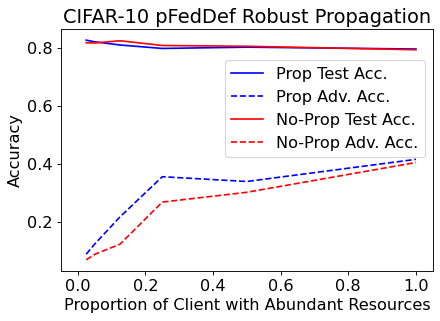

In [23]:
y_acc_prop = [0.8253663450479507, 0.8196936339139939, 0.808742442727089, 0.7967934012413025, 0.8011952921748161, 0.7948346763849259]
y_robust_prop = [0.08758858970787305, 0.12253153937471768, 0.21638445454554106, 0.35472260518954735, 0.33830196478714547, 0.41462931138200637]
y_target_prop = [0.4532700299225652, 0.3826173299475788, 0.28929452271087286, 0.19179320997552565, 0.210936906026939, 0.15371381280322868]

y1 = [y_acc_prop, y_robust_prop]

y_acc_no = [0.8164169147610665, 0.8156779795885086, 0.8233507379889489, 0.8070079997181893, 0.8042484283447265, 0.792279040813446]
y_robust_no = [0.06843173549158307, 0.08715279228800239, 0.12226455499812101, 0.2673846557449836, 0.30108329021813685, 0.4036964370463139]
y_target_no =  [0.4425674390011968, 0.4150387109316981, 0.3750597286933603, 0.2590276794882718, 0.22691747876278195, 0.15252137909977673]

y2= [y_acc_no, y_robust_no]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14.5}

plt.rc('font', **font)

names1 = ['Prop Test Acc.', 'Prop Adv. Acc.']
names2 = ['No-Prop Test Acc.', 'No-Prop Adv. Acc.']
colors = ['b','r']
types = ['-', '--']

plt.figure(figsize=(6, 4), dpi=80)
for i in range(len(names1)):
    plt.plot(x,y1[i],label= names1[i], linestyle = types[i], color = colors[0])
for i in range(len(names2)):
    plt.plot(x,y2[i],label= names2[i], linestyle = types[i], color = colors[1])
plt.legend(frameon=True,  loc= (0.44,0.47))
plt.xlim(-0.05, 1.05);
# plt.ylim(0, 1.0);
plt.xlabel('Proportion of Client with Abundant Resources')
plt.ylabel('Accuracy')
plt.title("CIFAR-10 pFedDef Robust Propagation")



Text(0.5, 1.0, 'CIFAR-10 pFedDef Robustness Propagation')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


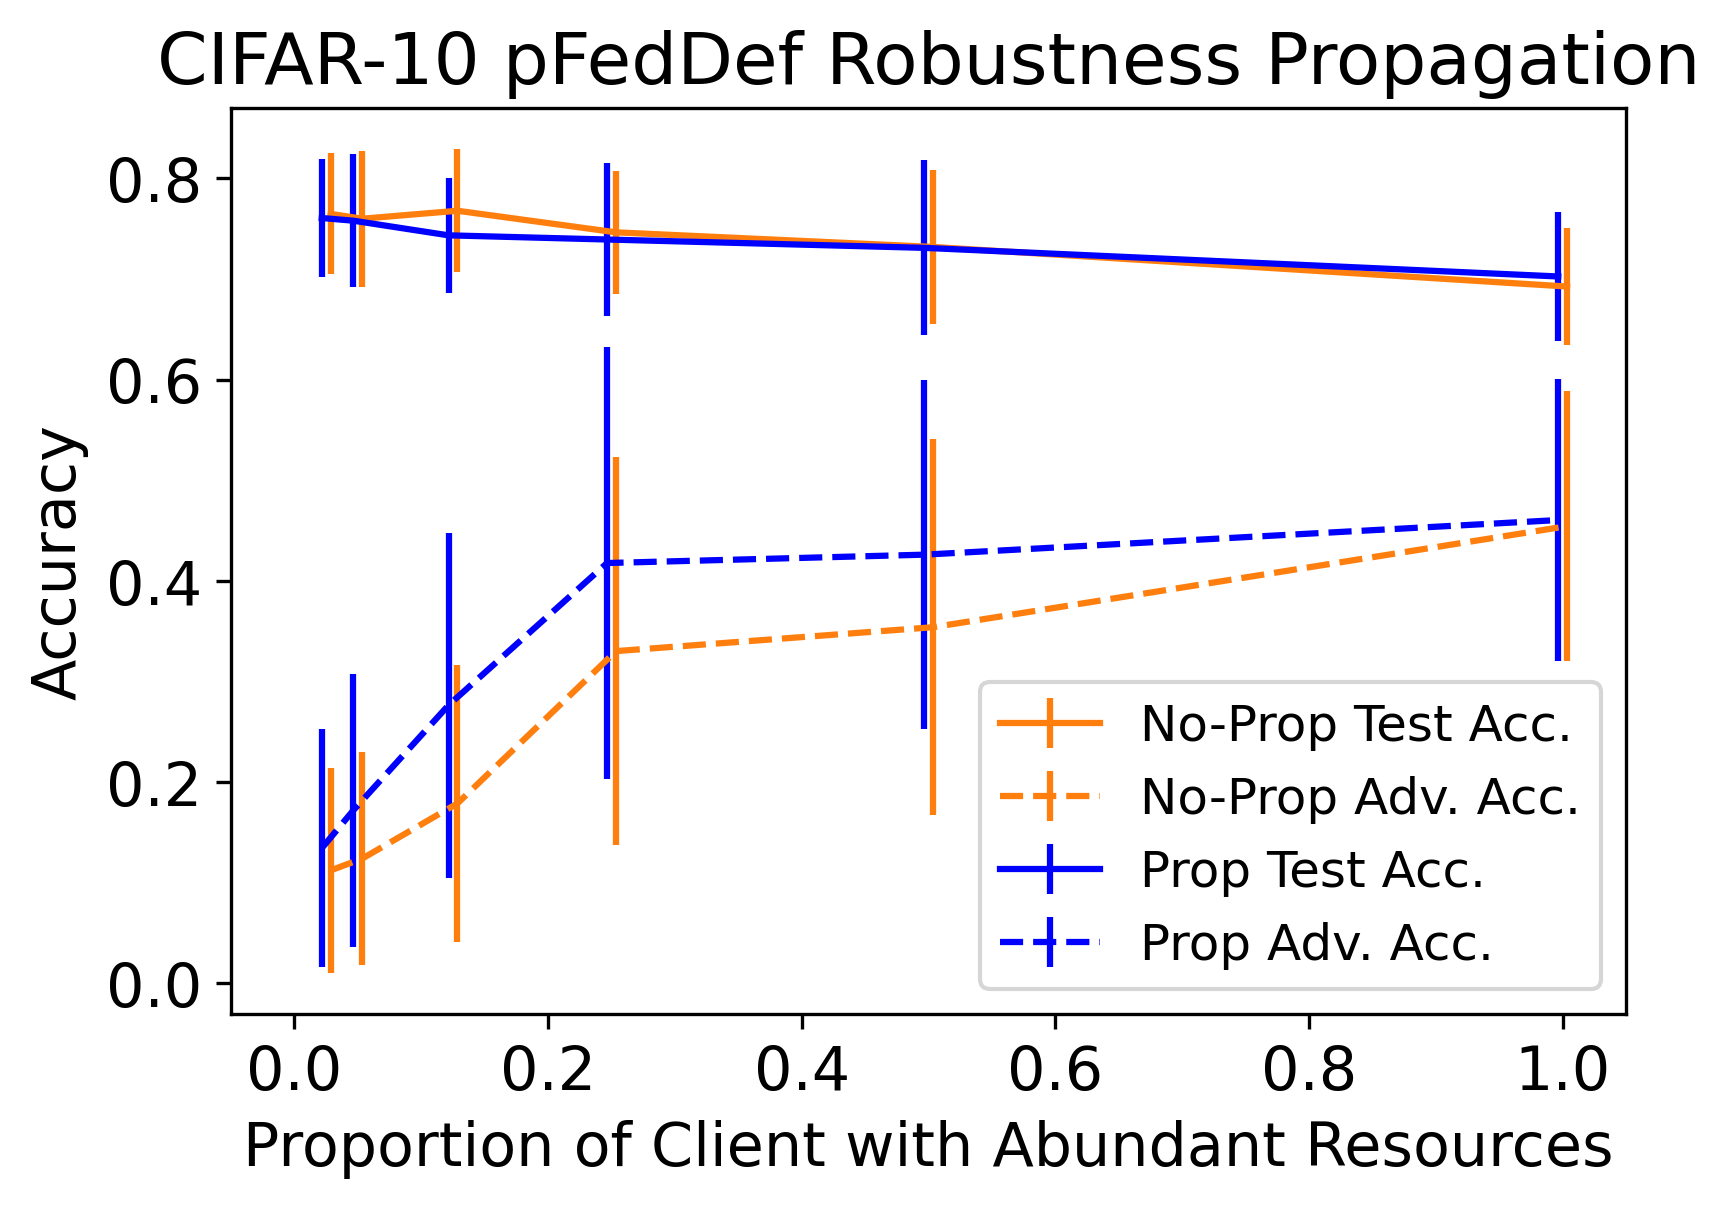

In [3]:
x = [1/40,2/40,5/40,10/40,20/40,40/40]


y_acc_prop = [0.7605353087186814, 0.7578409105539322, 0.7433026850223541, 0.7391504794359207, 0.7308612316846848, 0.7024198040366173]
y_robust_prop = [0.1341297878809154, 0.17194060569790265, 0.27635385000552887, 0.4175918556140879, 0.425900162302483, 0.46032147421382175]
y_target_prop = [0.4393017269097842, 0.3724898492069676, 0.28154387442180173, 0.19205983139407368, 0.21070790691748978, 0.15542222612495654]

y_acc_prop_std = [0.05829225443627427, 0.06597739074465195, 0.05743309585126492, 0.07559560480806257, 0.08693199380888766, 0.06441682034865502]
y_robust_prop_std =  [0.11822574422381488, 0.13555298839072924, 0.17149157642448473, 0.21487497541964806, 0.17353954694175072, 0.1399641019853764]
y_target_prop_std = [0.28073958022488277, 0.27164798577905175, 0.24122064229508086, 0.2113727029725666, 0.18001005684700064, 0.14601384749983068]

y1 = [y_acc_prop, y_robust_prop]
y1_std = [y_acc_prop_std, y_robust_prop_std]

y_acc_no = [0.764621390402317, 0.759826785326004, 0.7677241384983062, 0.7462851345539093, 0.7317697063088417, 0.6924181744456291]
y_robust_no = [0.11206931905367244, 0.12387201160741731, 0.17865584808616683, 0.33003244125642456, 0.3537969883614912, 0.45422496696313225]
y_target_no =   [0.4300169438577424, 0.40189082208865634, 0.35908170548948243, 0.25690408524346703, 0.22410570187315057, 0.14952245252893473]

y_acc_no_std = [0.06019149915455341, 0.06741443057788439, 0.06104554477744773, 0.06124123360146227, 0.07692681148875882, 0.058102520930639084]
y_robust_no_std = [0.1019524121671385, 0.10593409678658051, 0.13746154032631552, 0.19318630900175524, 0.1868397476948774, 0.13428536820895795]
y_target_no_std =  [0.27169847034702543, 0.26738584931703085, 0.26740528921166973, 0.2326159769096525, 0.18976940445306614, 0.14657469471958254]


y2= [y_acc_no, y_robust_no]
y2_std = [y_acc_no_std, y_robust_no_std]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14.5}

plt.rc('font', **font)

names1 = ['Prop Test Acc.', 'Prop Adv. Acc.']
names2 = ['No-Prop Test Acc.', 'No-Prop Adv. Acc.']
colors = ['b','tab:orange']
types = ['-', '--']

offset = 0.0035
plt.figure(figsize=(6, 4), dpi=300)

for i in range(len(names2)):
    plt.errorbar(np.array(x) + offset,y2[i],y2_std[i], label= names2[i], linestyle = types[i], color = colors[1])
#     plt.fill_between(x, np.array(y2[i]) - np.array(y2_std[i]), np.array(y2[i]) + np.array(y2_std[i]),
#                     alpha = 0.2, edgecolor = colors[1], facecolor=colors[1],linewidth=1, antialiased=True)
for i in range(len(names1)):
    plt.errorbar(np.array(x) - offset,y1[i],y1_std[i],label= names1[i], linestyle = types[i], color = colors[0])
#     plt.fill_between(x, np.array(y1[i]) - np.array(y1_std[i]), np.array(y1[i]) + np.array(y1_std[i]),
#                     alpha = 0.2, edgecolor = colors[0], facecolor=colors[0],linewidth=1, antialiased=True)
plt.legend(frameon=True,  loc= 'best',prop={'size': 12})
plt.xlim(-0.05, 1.05);
# plt.ylim(0, 1.0);
plt.xlabel('Proportion of Client with Abundant Resources')
plt.ylabel('Accuracy')
plt.title("CIFAR-10 pFedDef Robustness Propagation")

